In [1]:
import sys
sys.path.append('/Users/paolamartire/shocks')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import healpy as hp
from Utilities.basic_units import radians
from src import orbits as orb
from Utilities import sections as sec
import matplotlib.colors as colors
import Utilities.prelude as prel

from Utilities.operators import make_tree, to_spherical_components, to_cylindric
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 300

In [2]:
# HEALPIX
observers_xyz = hp.pix2vec(prel.NSIDE, range(prel.NPIX))
observers_xyz = np.array(observers_xyz).T
x, y, z = observers_xyz[:, 0], observers_xyz[:, 1], observers_xyz[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)   # Radius (should be 1 for unit vectors)
theta = np.arctan2(y, x)          # Azimuthal angle in radians
phi = np.arccos(z / r)            # Elevation angle in radians
longitude_moll = theta              
latitude_moll = np.pi / 2 - phi 
indecesorbital = np.concatenate(np.where(latitude_moll==0))
first_idx, last_idx = np.min(indecesorbital), np.max(indecesorbital)

In [3]:
abspath = '/Users/paolamartire/shocks'
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
gamma = 5/3
params = [Mbh, Rstar, mstar, beta]
check = '' # '' or 'HiRes' or 'LowRes'
snap = '348'
compton = 'Compton'

folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}{compton}{check}'
path = f'{abspath}/TDE/{folder}/{snap}'
saving_path = f'{abspath}/Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')

Rt = Rstar * (Mbh/mstar)**(1/3)
# Rs = 2*G*Mbh / c**2
R0 = 0.6 * Rt
Rp =  Rt / beta
omegaRp = np.sqrt(G*Mbh/Rp**3)
apo = orb.apocentre(Rstar, mstar, Mbh, beta)

# cfr tidal disruption and at smoothing lenght
xcfr, ycfr, cfr = orb.make_cfr(Rt)
xcfr0, ycfr0, cfr0 = orb.make_cfr(R0)
# cfr for grid
radii_grid = [R0, Rt, 0.1*apo, 0.3*apo, 0.5*apo, apo] #np.linspace(R0, apo,100)
styles = ['dotted', 'dashed', 'solid', 'solid', 'solid', 'solid']
xcfr_grid, ycfr_grid, cfr_grid = [], [], []
for i,radius_grid in enumerate(radii_grid):
    xcr, ycr, cr = orb.make_cfr(radius_grid)
    xcfr_grid.append(xcr)
    ycfr_grid.append(ycr)
    cfr_grid.append(cr)

We are in: /Users/paolamartire/shocks/TDE/R0.47M0.5BH10000beta1S60n1.5Compton/348, 
We save in: /Users/paolamartire/shocks/Figs/R0.47M0.5BH10000beta1S60n1.5Compton/


Load data

In [4]:
data = make_tree(path, snap, energy = True)
# dataph = np.loadtxt(f'{abspath}/data/R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}{compton}/_photo{snap}.txt')
# xph, yph, zph = dataph[0], dataph[1], dataph[2]  
# rph = np.sqrt(xph**2 + yph**2 + zph**2)
# dataphK = np.loadtxt(f'{abspath}/data/R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}{compton}/_photo{snap}Kextr.txt')
# xphK, yphK, zphK = dataphK[0], dataphK[1], dataphK[2]  
# rphK = np.sqrt(xphK**2 + yphK**2 + zphK**2)
# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

Rsph = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
vol = data.Vol
dim_cell = vol**(1/3) 
Diss_den, Press = data.Diss, data.Press
print('Diss density positive/negative: ', np.sum(Diss_den[Diss_den>0])/(np.sum(Diss_den[Diss_den<0])))
print('Diss positive/negative: ', np.sum(Diss_den[Diss_den>0]*vol[Diss_den>0])/(np.sum(Diss_den[Diss_den<0]*vol[Diss_den<0])))
# divV = np.load(f'{abspath}/TDE/{folder}/{snap}/divV_{snap}.npy')
# ie_den = data.IE
# ie_mass = ie_den/data.Den
# L = (4*np.pi*Rsph**2 * prel.csol_cgs * data.Rad) * prel.en_converter
# Edot_diss = np.abs(data.Diss) * data.Vol

tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')
dataph = np.loadtxt(f'/Users/paolamartire/shocks/data/{folder}/photo/_photo{snap}.txt')
xph, yph, zph, volph= dataph[0], dataph[1], dataph[2], dataph[3]

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]

Diss density positive/negative:  -69.88430155323704
Diss positive/negative:  -29.50759941022048


In [ ]:
xz = np.logical_and(data.Den>1e-19, np.abs(data.Y) < dim_cell)
X_xz, Y_xz, Z_xz, dim_xz, Mass_xz, Den_xz, Press_xz, Temp_xz, Diss_den_xz, Rad_xz, VX_mid, VY_mid, VZ_mid = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den, data.Press, data.Temp, Diss_den, data.Rad, data.VX, data.VY, data.VZ], xz)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
img = ax1.scatter(X_xz, Z_xz, c = Den_xz, s = 10, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-13, vmax = 1e-6))
cbar = plt.colorbar(img)
cbar.set_label(r'Density $[M_\odot/R_\odot^3]$')
ax1.set_ylabel(r'Z [$R_\odot$]')
img = ax2.scatter(X_xz, Z_xz, c = Mass_xz, s = 10, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-12, vmax = 1e-8))
cbar = plt.colorbar(img)
cbar.set_label(r'Cell mass $[R_\odot]$')
for ax in [ax1, ax2]:
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-50, 30)
    ax.set_ylim(-10, 10)
    ax.set_xlabel(r'X [$R_\odot$]')
plt.suptitle(r'Cross section, X=R$_p$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
# plt.savefig(f'{saving_path}/slices/yz{threshx}_{snap}.png')

In [ ]:
idxRp_lines = np.concatenate(np.where(np.logical_and(np.abs(Y_yz)<dim_yz, np.abs(Z_yz)<dim_yz))) #X=Rp, Y=0
PressRp, DenRp, YRp, ZRp, dimRp, TRp = Press_yz[idxRp_lines], Den_yz[idxRp_lines], Y_yz[idxRp_lines], Z_yz[idxRp_lines], dim_yz[idxRp_lines], Temp_yz[idxRp_lines]
idxRp = np.argmin(np.abs(ZRp)) #X=Rp, Y=0, Z=0
print('Rp coordinates Y, Z: ', YRp[idxRp], ZRp[idxRp])
csRp = np.sqrt(PressRp[idxRp]/DenRp[idxRp])
Hrp = csRp/omegaRp
print(f'Minimum R cell size: {np.min(dim_yz)}')
print(f'T = {TRp[idxRp]/1e6} 1e6 K')
print(f'Cs at Rp: {csRp*prel.Rsol_cgs*1e-7/prel.tsol_cgs} 1e-7 cm/s \nH at Rp: {Hrp} Rsol')
print(f'max numbers of cell in H: {Hrp/np.min(dim_yz)}')


In [ ]:
threshy = 20
xz = np.abs(data.Y-threshy) < dim_cell
X_xz, Y_xz, Z_xz, dim_xz, Mass_xz, Den_xz, Temp_xz, Diss_den_xz, Rad_xz, VX_mid, VY_mid, VZ_mid, divV_mid = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den, data.Temp, Diss_den, data.Rad, data.VX, data.VY, data.VZ, divV], xz)
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_xz/apo, Z_xz/Rt, c = Den_xz, s = 7, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-13, vmax = 1e-4))
cbar = plt.colorbar(img)
cbar.set_label(r'Density', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-1.5, 0.5)
ax.set_ylim(-4, 4)
ax.axhline(-2, color = 'k', linestyle = '--')    
ax.axhline(2, color = 'k', linestyle = '--')
ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_t$]', fontsize = 18)
plt.title(f'Cross section, Y={threshy}, ' +r't/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.savefig(f'{saving_path}/slices/xz{threshy}Den_{snap}.png')

In [5]:
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, Press_midplane, Temp_midplane, Diss_den_midplane, Rad_midplane, VX_mid, VY_mid, VZ_mid, Press_mid = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den, data.Press, data.Temp, Diss_den, data.Rad, data.VX, data.VY, data.VZ, Press], midplane)
kappa_mid = Press_midplane / Den_midplane**gamma
V_mid = np.sqrt(VX_mid**2 + VY_mid**2 + VZ_mid)
vol_mid = dim_midplane**3
Diss_midplane = Diss_den_midplane * vol_mid
Rsph_mid = np.sqrt(X_midplane**2 + Y_midplane**2 + Z_midplane**2)
long_mid = np.arctan2(Y_midplane, X_midplane)          # Azimuthal angle in radians
lat_mid = np.arccos(Z_midplane/ Rsph_mid)            # Elevation angle in radians
v_rad_mid, v_theta_mid, v_phi_mid = to_spherical_components(VX_mid, VY_mid, VZ_mid, lat_mid, long_mid)
v_rad_mid_cgs = v_rad_mid * prel.Rsol_cgs/prel.tsol_cgs
v_rad_mid_kms = v_rad_mid_cgs * 1e-5

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_40871/1022985052.py:5: RuntimeWarning: invalid value encountered in sqrt
  V_mid = np.sqrt(VX_mid**2 + VY_mid**2 + VZ_mid)


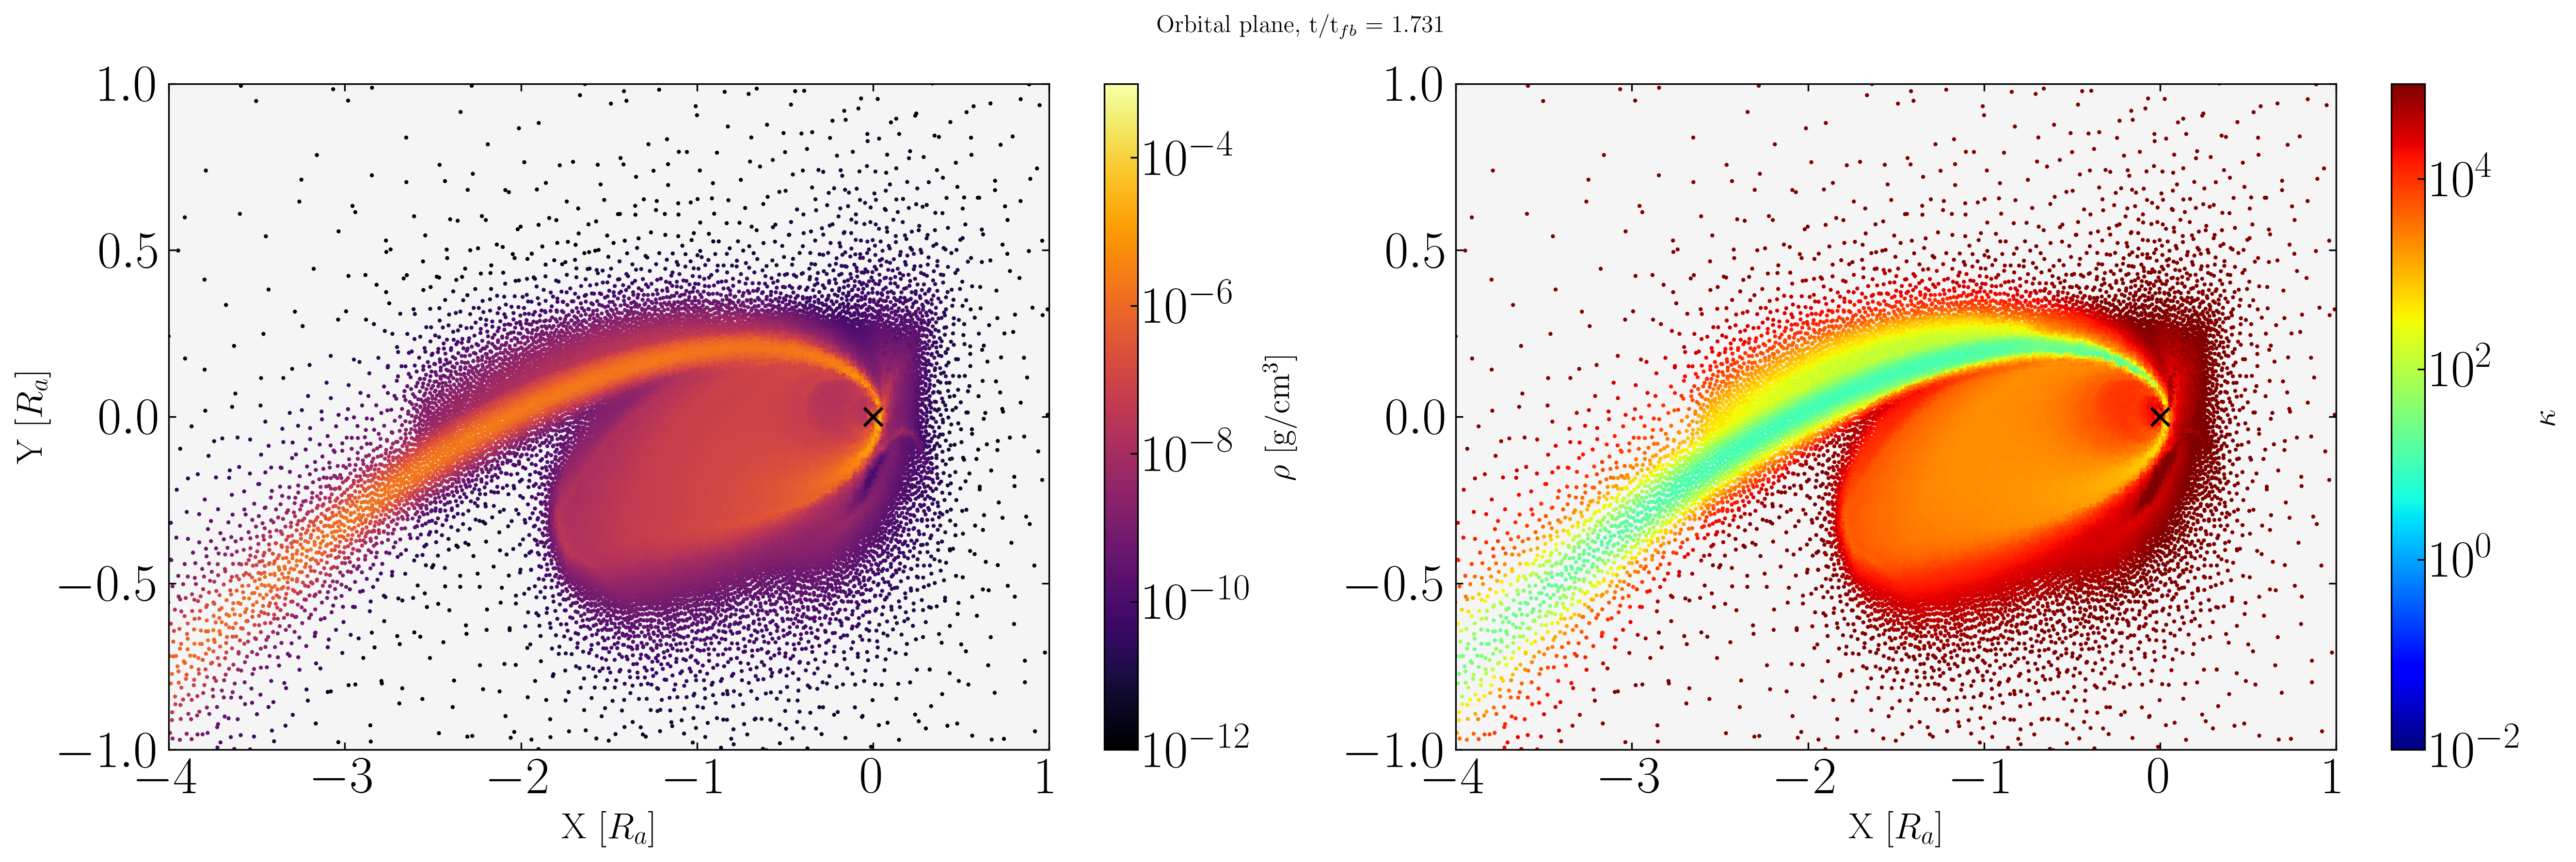

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane*prel.den_converter, s = 1, cmap = 'inferno', norm = colors.LogNorm(vmin =1e-12, vmax = 1e-3))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = kappa_mid, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-2, vmax=1e5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\kappa$', fontsize = 16)


for ax in [ax1, ax2]:
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-4, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.suptitle(r'Orbital plane, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
plt.savefig(f'{saving_path}kappa_{snap}.png')

In [ ]:
idxRp_lines_mid = np.concatenate(np.where(np.logical_and(np.abs(Y_midplane)<dim_midplane, np.abs(X_midplane-Rp)<dim_midplane))) #X=Rp, Y=0
PressRp_mid, DenRp_mid, XRp_mid, YRp_mid, dimRp_mid, TRp_mid = Press_midplane[idxRp_lines_mid], Den_midplane[idxRp_lines_mid], X_midplane[idxRp_lines_mid], Y_midplane[idxRp_lines_mid], dim_midplane[idxRp_lines_mid], Temp_midplane[idxRp_lines_mid]
idxRp_mid = np.argmin(np.abs(XRp_mid-Rp)) #Z=0, Y=0, X=Rp
print('Rp coordinates X, Y: ', XRp_mid[idxRp_mid], YRp_mid[idxRp_mid])
csRp_mid = np.sqrt(PressRp_mid[idxRp_mid]/DenRp_mid[idxRp_mid])
Hrp_mid = csRp_mid/omegaRp
print(f'Minimum R cell size: {np.min(dim_midplane)}')
print(f'T = {TRp_mid[idxRp_mid]/1e6} 1e6 K')
print(f'Cs at Rp: {csRp_mid*prel.Rsol_cgs*1e-7/prel.tsol_cgs} 1e-7 cm/s \nH at Rp: {Hrp_mid} Rsol')
print(f'max numbers of cell in H: {Hrp_mid/np.min(dim_midplane)}')

In [ ]:
absvel = True
fig, ax = plt.subplots(1,1, figsize = (12,6))
if absvel:
    img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = np.abs(v_rad_mid_kms), s = 4, cmap = 'jet', norm = colors.LogNorm(vmin = 5e2, vmax = 2e4))
else:
    img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = v_rad_mid_kms*1e-4, s = 4, cmap = 'jet', vmin = -1, vmax = 1)#, vmin = 5e2, vmax = 2e4)
cbar = plt.colorbar(img)
ax.scatter(xph[indecesorbital]/apo, yph[indecesorbital]/apo, facecolor = 'none', edgecolors = 'k')
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-6, 2.5)
ax.set_ylim(-3, 2)
ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_a$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
if absvel:
    cbar.set_label(r'$|$Radial velocity$|$ [km/s]', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'{saving_path}/slices/absvel{snap}.png')
else:
    cbar.set_label(r'Radial velocity [10$^4$ km/s]', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'{saving_path}/slices/vel{snap}.png')


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane, Y_midplane, c = Den_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-10, vmax = 1e-4))
cbar = plt.colorbar(img)
cbar.set_label(r'Density', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-400, 50)
ax.set_ylim(-100, 100)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
# plt.savefig(f'{saving_path}/slices/midplaneTemp_{snap}.png')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Diss_midplane, s = 1, cmap = 'inferno', vmin = -1e-15, vmax = 1e-15)
cbar = plt.colorbar(img)
cbar.set_label(r'Dissipation rate [energy/time]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = divV_mid, s = 1, cmap = 'inferno', vmin = -1, vmax=1)#1e2, vmax = 1e9)
cbar = plt.colorbar(img)
cbar.set_label(r'$\nabla v$ [1/time]', fontsize = 16)
for ax in [ax1, ax2]:
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-1.2, 0.3)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.suptitle(r'Orbital plane, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
plt.savefig(f'{saving_path}midplaneDiss_{snap}.png')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize = (12,4))
# img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = EdotDiss_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-15, vmax = 1e-6))
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\dot{E}_{diss}$ ', fontsize = 16)
# ax.scatter(0,0,c= 'k', marker = 'x', s=80)
# ax.text(-3.5,1.5, r'E diss tot =' + str(np.round(np.sum(Edot_diss)*1e5,2)) + r'$x$1e-5', fontsize = 16)
# ax.text(-3.5,1, r'E diss mid =' + str(np.round(np.sum(EdotDiss_midplane)*1e5,2)) + r'$x$1e-5', fontsize = 16)
# ax.set_xlim(-4,0.5)
# ax.set_ylim(-2,2)
# ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check = {check}', fontsize = 18)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = Rad_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin= 1e-8, vmax = 5e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'Energy density [erg/cm$^3$]', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-1,0.1)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = L_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin= 1e40, vmax = 1e46))
cbar = plt.colorbar(img)
cbar.set_label(r'Luminosity [erg/s]', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-8,0.1)
ax.set_ylim(-2,2)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

In [ ]:
# search for indeces to explore
selected_indeces = np.arange(30,230,20)
plt.plot(x_stream, y_stream, c = 'k')
plt.scatter(x_stream[selected_indeces], y_stream[selected_indeces], c = 'b')
plt.xlim(-apo,100)
plt.ylim(-100,100)

Tangent and transverse plane

In [ ]:
idx = 80
condition_tra, x_onplane, x0 = sec.transverse_plane(data.X, data.Y, data.Z, dim_cell, x_stream, y_stream, z_stream, idx, coord= True)
X_tra, Y_tra, Z_tra, Vz_tra, Den_tra, Mass_tra, dim_tra = \
    sec.make_slices([data.X, data.Y, data.Z, data.VZ, data.Den, data.Mass, dim_cell], condition_tra)
X_tra_midplane = X_tra[np.abs(Z_tra) < dim_tra]
Y_tra_midplane = Y_tra[np.abs(Z_tra) < dim_tra]

Plot as BonnerotLu22

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.scatter(x_onplane/Rstar, Den_tra, s=.1, c='k')
ax1.set_xlabel(r'T/R$_\star$')
ax1.set_ylabel(r'Density [M$_\odot$/R$_\odot^3$]')
ax1.set_xlim(-15,15)
ax1.grid()

ax2.scatter(Z_tra/Rstar, Vz_tra, s=.1, c='k')
ax2.set_xlabel(r'Z/R$_\star$')
ax2.set_ylabel(r'V$_z [R_\odot/\tilde{t}$]')
ax2.set_xlim(-6.5,6.5)
ax2.set_ylim(-0.5, 0.5)
ax2.grid()

plt.tight_layout()
plt.suptitle('Reproducing Fig.3 from BonnerotLu22')

In [ ]:
indeces_boundary, x_T_width, w_params, h_params, thresh = orb.find_single_boundaries(data.X, data.Y, data.Z, dim_cell, data.Mass, stream , idx, params)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14,4), gridspec_kw = {'width_ratios': [2, 1]})
img = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = 0.1*np.max(Den_tra), vmax = np.max(Den_tra))
cbar = plt.colorbar(img)
cbar.set_label(r' Density', fontsize = 16)
ax[0].scatter(X_tra_midplane, Y_tra_midplane, s = 1, c = 'k')
ax[0].set_xlim(-300,20)
ax[0].set_ylim(-60,60)

img1 = ax[1].scatter(x_onplane, Z_tra, c = Den_tra,  cmap = 'viridis', s = 27, vmin = 0.1*np.max(Den_tra), vmax = np.max(Den_tra))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Density', fontsize = 16)
ax[1].scatter(0, z_stream[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[1].axvline(x_T_width[0], c = 'r')
ax[1].axvline(x_T_width[1], c = 'r') # T coordinates for width
ax[1].axvline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].axvline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].text(0.9*thresh, -1.8*thresh, 'cutoff',fontsize = 11, rotation = 90,  bbox=dict(facecolor='white', alpha=0.8))
ax[1].set_xlim(-2*thresh, 2*thresh)

ax[1].axhline(data.Z[indeces_boundary[2]], c = 'r')
ax[1].axhline(data.Z[indeces_boundary[3]], c = 'r')
ax[1].axhline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].axhline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].set_ylim(-2*thresh, 2*thresh)

ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18) 
plt.suptitle(f'{check}, cells W: {int(w_params[1])}, cells H: {int(h_params[1])}, theta: {np.round(theta_arr[idx], 2)}', fontsize = 16)
plt.tight_layout()
